# Luhman 16 in 2021A?

We want to figure out what sort of flux-sampling we can expect with IGRINS over the course of 2 TESS Sectors.

In [1]:
import astroplan

import lightkurve as lk
import glob
from lightkurve.lightcurve import LightCurve

from astroquery.mast import Observations

# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm
import warnings

import sys
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We can use astroquery to download the `PATHOS` lightcurve.  astroquery caches the result so no need to re-downloaded.

In [2]:
redownload=False

In [3]:
if redownload:
    sector_num = '10'
    print('Querying for PATHOS Sector ' + sector_num + " Observations of Luhman 16.")
    obsTable = Observations.query_criteria(provenance_name = "PATHOS", objectname='Luhman 16',
                                           sequence_number = sector_num)

    print("Found a total of " + str(len(obsTable)) + " PATHOS targets.")
    print('Downloading data products for these observations...')
    for obs in obsTable:
        data_products = Observations.get_product_list(obs)
        Observations.download_products(data_products, '../data/TESS/')

In [4]:
fns = glob.glob('../data/TESS/**/*.fits', recursive=True)
fn = fns[0]

In [5]:
lc = LightCurve.read(fn, format='pathos')

Woohoo!  We have the lightcurve!

In [6]:
%%capture
lc = lc.remove_outliers(sigma=5).normalize()

In [7]:
missing_data = lc.flux < 0.87
too_early = lc.time.value < 1572.5
too_early2 = (lc.time.value > 1583.0) & (lc.time.value < 1586)
lc = lc[~missing_data & ~too_early & ~too_early2]

In [8]:
n_epochs = 11
epochs = np.random.choice(lc.time.value, size=n_epochs)

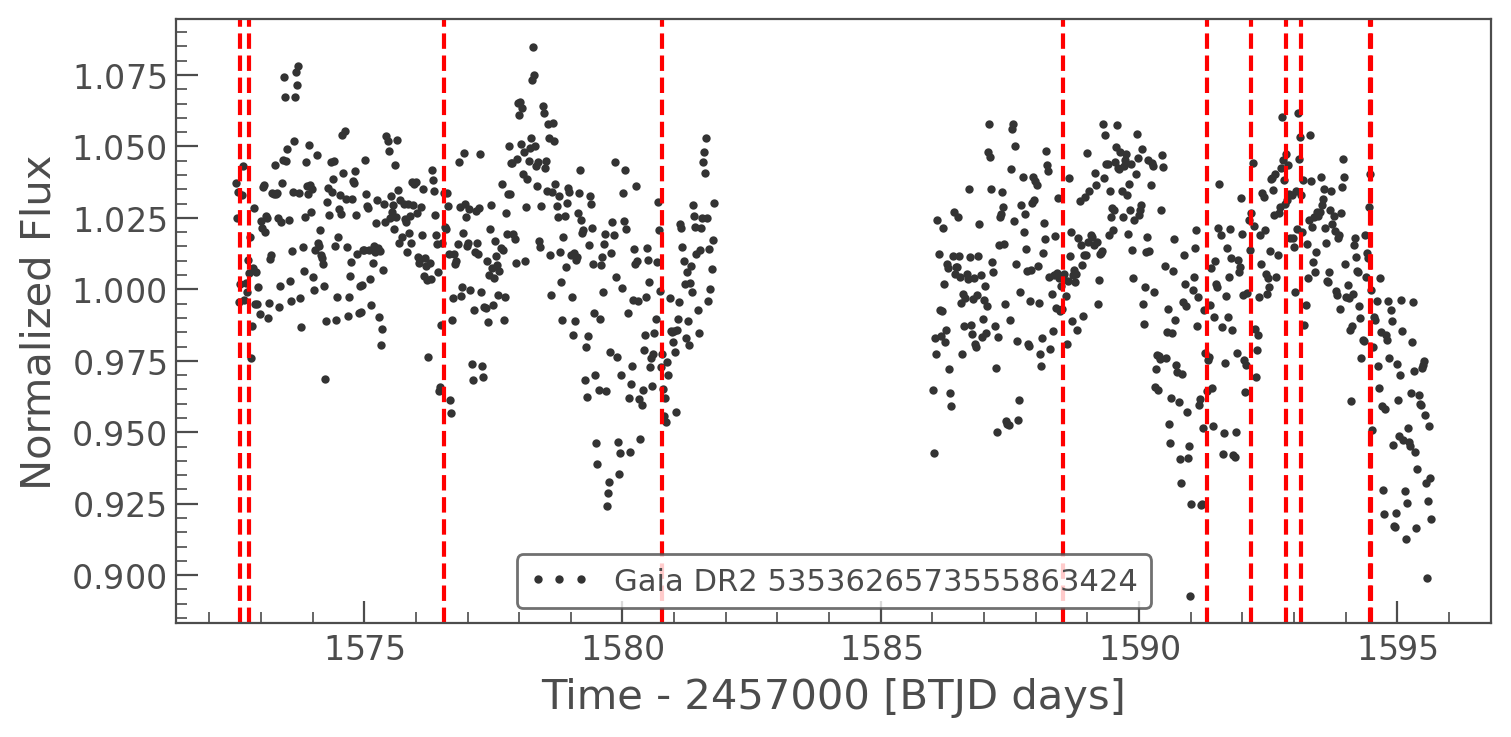

In [9]:
lc.plot(marker='o', linestyle='none')
for epoch in epochs:
    plt.axvline(epoch, color='r', linestyle='dashed')

In [10]:
index_mask = np.in1d(lc.time.value, epochs)

In [11]:
fluxes = lc.flux.value[index_mask]

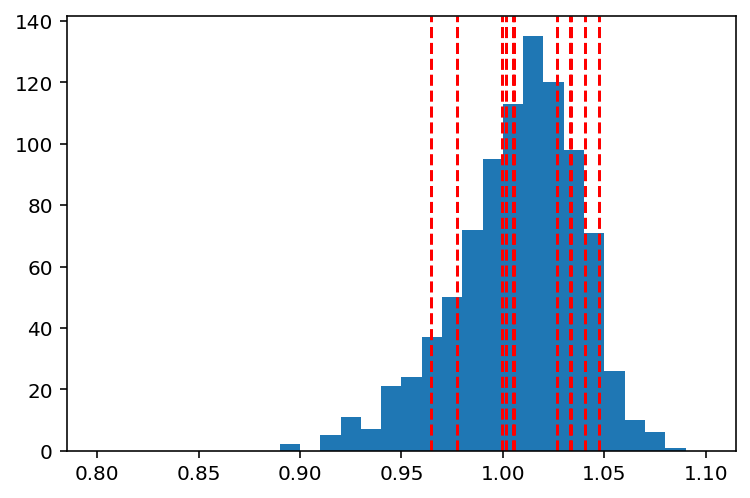

In [12]:
plt.hist(lc.flux, bins=np.arange(0.8, 1.1, 0.01));
for flux in fluxes:
    plt.axvline(flux, color='r', linestyle='dashed')

Neat!  But not all times are observable from the ground.  Let's use astroplan to figure out observing windows.

## Projecting ahead with Astropy

In [13]:
from astroplan import Observer
from astroplan import FixedTarget
from astroplan import observability_table
from astropy.time import Time

In [14]:
gemini = Observer.at_site('gemini south')

In [15]:
target = FixedTarget.from_name('Luhman 16')

In [39]:
time_start = Time('2021-03-08 00:00:00') #start of Semester
time_end = Time('2021-03-18 00:00:00') #end of Semester

In [40]:
sunset_start = gemini.sun_set_time(time_start, which='nearest')
sunrse_start = gemini.sun_rise_time(time_start, which='nearest')
sunset_start.iso, sunrse_start.iso

('2021-03-07 23:05:14.580', '2021-03-08 10:42:39.701')

In [41]:
sunset_end = gemini.sun_set_time(time_end, which='nearest')
sunrse_end = gemini.sun_rise_time(time_end, which='nearest')
sunset_end.iso

'2021-03-17 22:53:21.016'

In [42]:
con1 = astroplan.AtNightConstraint().twilight_astronomical()
con2 = astroplan.AirmassConstraint(2.0)
at_night_low_airmass = [con1, con2]

In [48]:
time_range = (sunset_start, sunrse_end)

In [49]:
from astroplan.utils import time_grid_from_range

In [50]:
sector_36_times = (sunrse_start + (lc.time -lc.time.min()))
#sector_37_times = (sector_37_start + (lc.time -lc.time.min()))

In [51]:
at_night_low_airmass[0]

In [52]:
observability_grid1 = con1(gemini, target, times=sector_36_times)
observability_grid2 = con2(gemini, target, times=sector_36_times)
observability_grid_36 = observability_grid1 & observability_grid2

In [53]:
lc_future = lc.copy()

In [65]:
lc_future.time = sector_36_times+0.5

In [66]:
all_times = np.hstack([lc_future.time.value])
observability = np.hstack([observability_grid_36 & (lc_future.time.value < 2291)])
all_fluxes = np.hstack([lc_future.flux.value])

In [67]:
observable_times = all_times[observability]

In [134]:
n_epochs = 5
epochs = np.random.choice(observable_times,
                          size=n_epochs)

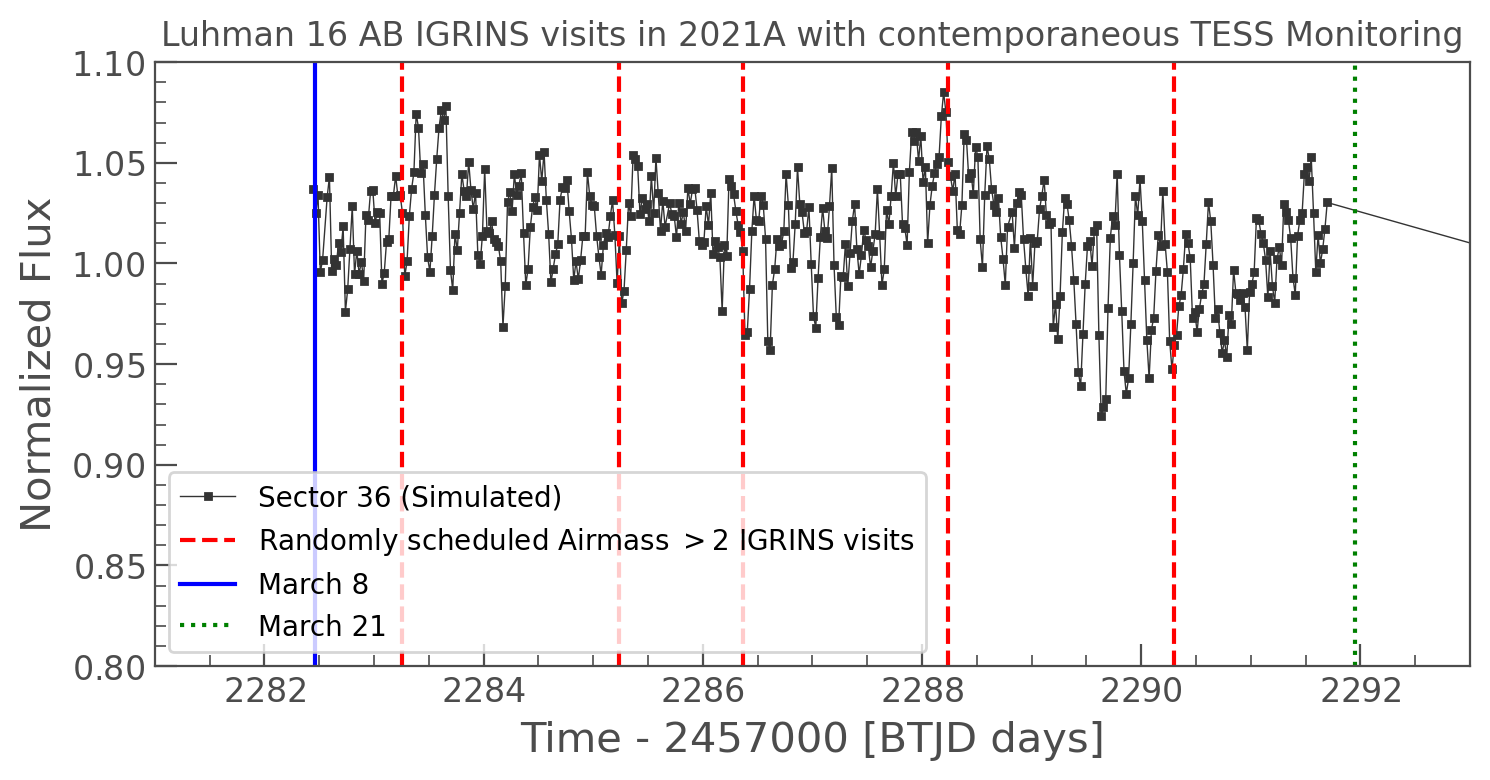

In [135]:
ax = lc_future.plot(marker='s', label='Sector 36 (Simulated)')
ax.axvline(epochs[0], color='r', linestyle='dashed', label='Randomly scheduled Airmass $>2$ IGRINS visits')

for epoch in epochs[1:]:
    plt.axvline(epoch, color='r', linestyle='dashed')
    
plt.axvline(sunset_start.btjd+1, linestyle='solid', color='b', label='March 8')
plt.axvline(sunrse_end.btjd, linestyle='dotted', color='g', label='March 21')

plt.ylim(0.8, 1.10)
plt.xlim(2281, 2293)
plt.title('Luhman 16 AB IGRINS visits in 2021A with contemporaneous TESS Monitoring')
plt.legend()
plt.savefig('../proposal/2021A/DDT/tess_luhman16/figures/Luhman16AB_IGRINS_2021A_TESS_scheduling.pdf', bbox_inches='tight')

In [121]:
#! xdg-open  ../

In [136]:
index_mask = np.in1d(all_times, epochs)

In [137]:
fluxes = all_fluxes[index_mask]

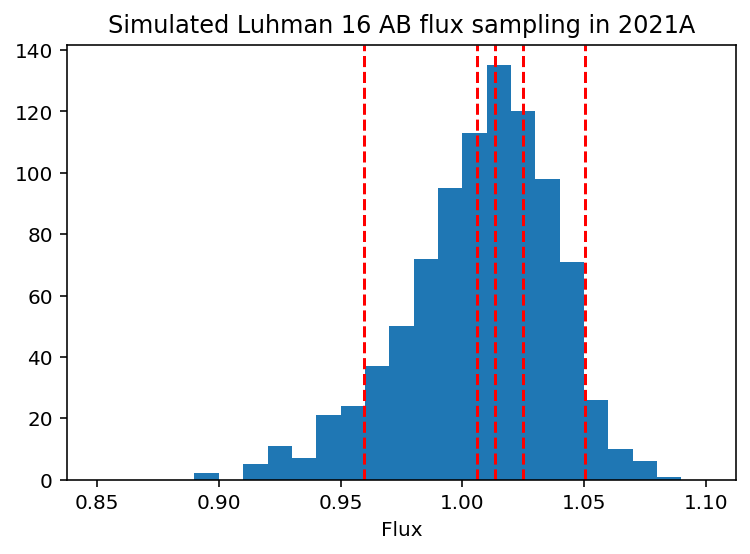

In [138]:
plt.hist(lc.flux, bins=np.arange(0.85, 1.1, 0.01));
#plt.hist(lc.flux[observability], bins=np.arange(0.85, 1.1, 0.01));

for flux in fluxes:
    plt.axvline(flux, color='r', linestyle='dashed')
plt.xlabel('Flux')
plt.title('Simulated Luhman 16 AB flux sampling in 2021A')
plt.savefig('../proposal/2021A/DDT/tess_luhman16/figures/Luhman16AB_IGRINS_2021A_TESS_flux_sampling.pdf', dpi=300, bbox_inches='tight')

In [101]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

The end!